# Differential gene expression

Using Normalisr.

# 0. Loading the libraries

In [1]:
import warnings

warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
import scanpy as sc
import numpy as np
from numpy import array, empty
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import gseapy as gp
from gseapy.plot import dotplot

import normalisr.normalisr as norm
from adjustText import adjust_text

from pyorthomap import findOrthologsHsMm

import pickle

def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [3]:
# Set up constants
save_folder = "figures/"
objects_folder = "saved_objects/"
sc.settings.figdir = './'+save_folder

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3

# 1. Reading in the data

In [4]:
# Load the pre-processed data

with open('saved_objects/adata_annotated.pkl', 'rb') as inp:
    adata = pickle.load(inp)

In [5]:
diseases = ["ms", "pr", "crohn", "t1d", "sle"]
GWAS_tmp = []

for disease in diseases:
    gwas_file = "files/"+disease+".tsv"
    gwas_list = pd.read_csv(gwas_file, header = 0, sep = "\t")[["REPORTED GENE(S)", "PVALUE_MLOG"]]
    genes = []
    for gene in gwas_list["REPORTED GENE(S)"].tolist():
        if str(gene) not in ['nan', 'intergenic', 'NR', 'Intergenic']:
            if len(gene.split(',')) == 1:
                genes.append(gene)
            else:
                genes.append(gene.split(',')[0])
    GWAS_tmp.append(list(set(genes)))

In [6]:
def replace(x):
    if len(x.tolist()) == 1:
        if x.tolist()[0] != x.tolist()[0]:
            return "NA"
        else:
            return(x.tolist()[0])
    else:
        return "NA"

def convert_genes(lgenes):
    translated = findOrthologsHsMm(from_filters = 'hgnc_symbol',
                  from_values = lgenes).map()
    return [replace(translated[translated.external_gene_name == e]["external_gene_name"]) for e in adata.var['gene_name']]

GWAS = {}
for i in range(len(diseases)):
    GWAS[diseases[i]] = convert_genes(GWAS_tmp[i])

# add sp140
GWAS['crohn'].extend(['Sp140', 'Sp110'])
GWAS['ms'].extend(['Sp140'])
GWAS['pr'].extend(['Sp140'])

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
tf_file1 = 'files/mm_mgi_tfs.txt'
tf_list1 = pd.read_table(tf_file1, delimiter='\t', header=None).rename(columns={0:"Symbol"})
tf_file2 = 'files/Mus_musculus_TF.txt'
tf_list2 = pd.read_table(tf_file2, delimiter='\t')
tf_list = pd.concat([tf_list1,tf_list2]).drop_duplicates().reset_index(drop=True).Symbol

In [8]:
atacD2_D3 = pd.read_table("files/D2_D3_DARs_GeneMerged.txt", sep = "\t")
atacD2_D3 = atacD2_D3[["GeneSymbol", "annotation"]]
atacD2_D3.columns = ['gene', 'annotation']

atacD2_D3_D7 = pd.read_table("files/D2_D3_D7_DARs_GeneMerged.txt", sep = "\t")
atacD2_D3_D7 = atacD2_D3_D7[["GeneSymbol", "annotation"]]
atacD2_D3_D7.columns = ['gene', 'annotation']

In [9]:
n6_6 = pd.read_csv("files/affy_6h_annotated_liste_de_0.01_Pack1_Pack2.txt", sep = "\t")[["Symbol", "logFC", "Ratio"]]
n6_6 = n6_6[n6_6.Symbol == n6_6.Symbol]
n6_6["Gene"] = [e.split(", ")[0] if len(e.split(", ")) > 1 else e for e in n6_6["Symbol"]]
ind_n6_6 = list(set(n6_6[n6_6.logFC < -1].Gene.tolist()))
inh_n6_6 = list(set(n6_6[n6_6.logFC > 1].Gene.tolist()))

# 2. Differential expression

In [10]:
def correct_pvalues_for_multiple_testing(pvalues):

    pvalues = array(pvalues)
    sample_size = pvalues.shape[0]
    qvalues = empty(sample_size)
    values = [(pvalue, i) for i, pvalue in enumerate(pvalues)]
    values.sort()
    values.reverse()
    new_values = []
    for i, vals in enumerate(values):
        rank = sample_size - i
        pvalue, index = vals
        new_values.append((sample_size/rank) * pvalue)
    for i in range(0, int(sample_size)-1):
        if new_values[i] < new_values[i+1]:
            new_values[i+1] = new_values[i]
    for i, vals in enumerate(values):
        pvalue, index = vals
        qvalues[index] = new_values[i]
        
    return qvalues

In [11]:
def de_test(sub1, sub2, dc_, dt_, dt_mean_, gene_names):

    # Create the grouping variable
    dg = np.array([0 for i in range(dt_.shape[1])])
    dg[sub1.tolist()] = 1
    dg[sub2.tolist()] = 2
    dg = np.array([dg])
    
    # Subset dt and dc
    dt_mean_ = dt_mean_[:,dg[0] != 0].copy()
    dt_ = dt_[:,dg[0] != 0].copy()
    dc_ = dc_[:,dg[0] != 0].copy()
    dg = dg[:,dg[0] != 0].copy()

    # Compute mean expression
    mat = np.where(
        dt_mean_>0,
        dt_mean_,
        np.nan).T
    sums = np.count_nonzero(~np.isnan(mat), axis=0)
    means = np.nanmean(mat,axis=0)
    means[np.isnan(means)] = 0
    sums_bool = [0 if e<20 else 1 for e in sums]
    mean_expr = means * sums_bool
    expr_filt = list(mean_expr > 0)
    genes = gene_names[expr_filt].tolist()

    if not("Il10" in genes):
        expr_filt[gene_names.tolist().index("Il10")] = True
        genes = gene_names[expr_filt].tolist()

    mean_expr = mean_expr[expr_filt]

    # Keep only expressed genes
    dt_ = dt_[expr_filt,:].copy()

    # Perform de (only one grouping)
    de_naive = norm.de(dg,dt_,dc_)

    pval = list(de_naive[0][0])
    qval = correct_pvalues_for_multiple_testing(pval)
    lfc = list(de_naive[1][0])

    res = pd.DataFrame({"gene" : genes, "pval" : pval, "qval" : qval, "log2fc" : lfc, "mean" : mean_expr})

    dt1 = dt_[:, dg[0] == 1].mean(axis = 1)
    dt2 = dt_[:, dg[0] == 2].mean(axis = 1)
    genes_filt = [gene == "Il10" for gene in genes]
    m1 = dt1[genes_filt]
    m2 = dt2[genes_filt]
    if m1 > m2 : print("Subset 1 has higher Il10 expression")
    elif m1 < m2 : print("Subset 2 has higher Il10 expression")

    return res

In [12]:
# Inputs for normalisr

dt0 = adata.raw.X[:, [not(gene.startswith(("mt-", 'Rps', "Rpl"))) for gene in adata.var['gene_name']]].T
dc0 = np.array(adata.obs[["n_counts", "n_genes"]]).T

In [13]:
# Normalisation for normalisr
dt,_,_,dc2 = norm.lcpm(dt0)
dc=np.concatenate([dc0,dc2],axis=0)
dc=norm.normcov(dc)
sf=norm.scaling_factor(dt0)
weight=norm.compute_var(dt,dc)
dt,dc=norm.normvar(dt,dc,weight,sf)

In [ ]:
filt = [not(gene.startswith(("mt-", 'Rps', "Rpl"))) for gene in adata.var['gene_name']]
gene_names = adata.var.gene_name[filt]

In [ ]:
tests = []
names = []
TEST = "normalisr"

In [ ]:
# Control
tests.append(de_test((adata.obs['sample'] == "NAIVE_0h-1"), (adata.obs['sample'] == "NAIVE_0h-2"), dc, dt, dt0, gene_names))
names.append("NAIVE_0h-1vsNAIVE_0h-2_"+TEST)
print(names[-1])

# N6 vs DMSO
tests.append(de_test((adata.obs['cond'] == "N6"), (adata.obs['cond'] == "DMSO"), dc, dt, dt0, gene_names))
names.append("N6vsDMSO_"+TEST)
print(names[-1])

tests.append(de_test((adata.obs['cond'] == "N6") & (adata.obs['tp'] == "2h"), (adata.obs['cond'] == "DMSO") & (adata.obs['tp'] == "2h"), dc, dt, dt0, gene_names))
names.append("N6vsDMSO_2h_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['cond'] == "N6") & (adata.obs['tp'] == "24h"), (adata.obs['cond'] == "DMSO") & (adata.obs['tp'] == "24h"), dc, dt, dt0, gene_names))
names.append("N6vsDMSO_24h_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['cond'] == "N6") & (adata.obs['tp'] == "48h"), (adata.obs['cond'] == "DMSO") & (adata.obs['tp'] == "48h"), dc, dt, dt0, gene_names))
names.append("N6vsDMSO_48h_"+TEST)
print(names[-1])

tests.append(de_test((adata.obs['cond'] == "N6") & (adata.obs['Il10_positive'] == "Il10+"), (adata.obs['cond'] == "DMSO") & (adata.obs['Il10_positive'] == "Il10+"), dc, dt, dt0, gene_names))
names.append("N6vsDMSO_IL10Pos_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['cond'] == "N6") & (adata.obs['Il10_positive'] == "Il10+") & (adata.obs['tp'] == "24h"), 
                                  (adata.obs['cond'] == "DMSO") & (adata.obs['Il10_positive'] == "Il10+") & (adata.obs['tp'] == "24h"), dc, dt, dt0, gene_names))
names.append("N6vsDMSO_IL10Pos24h_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['cond'] == "N6") & (adata.obs['Il10_positive'] == "Il10+") & (adata.obs['tp'] == "48h"), 
                                  (adata.obs['cond'] == "DMSO") & (adata.obs['Il10_positive'] == "Il10+") & (adata.obs['tp'] == "48h"), dc, dt, dt0, gene_names))
names.append("N6vsDMSO_IL10Pos48h_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['cond'] == "N6") & (adata.obs['Il10_positive'] == "Il10+") & (adata.obs['tp'] == "d7"), 
                                  (adata.obs['cond'] == "DMSO") & (adata.obs['Il10_positive'] == "Il10+") & (adata.obs['tp'] == "d7"), dc, dt, dt0, gene_names))
names.append("N6vsDMSO_IL10Posd7_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['cond'] == "N6") & (adata.obs['Il10_positive'] == "Il10-"), (adata.obs['cond'] == "DMSO") & (adata.obs['Il10_positive'] == "Il10-"), dc, dt, dt0, gene_names))
names.append("N6vsDMSO_IL10Neg_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['cond'] == "N6") & (adata.obs['Il10_positive'] == "Il10-") & (adata.obs['tp'] == "24h"), 
                                  (adata.obs['cond'] == "DMSO") & (adata.obs['Il10_positive'] == "Il10-") & (adata.obs['tp'] == "24h"), dc, dt, dt0, gene_names))
names.append("N6vsDMSO_IL10Neg24h_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['cond'] == "N6") & (adata.obs['Il10_positive'] == "Il10-") & (adata.obs['tp'] == "48h"), 
                                  (adata.obs['cond'] == "DMSO") & (adata.obs['Il10_positive'] == "Il10-") & (adata.obs['tp'] == "48h"), dc, dt, dt0, gene_names))
names.append("N6vsDMSO_IL10Neg48h_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['cond'] == "N6") & (adata.obs['Il10_positive'] == "Il10-") & (adata.obs['tp'] == "d7"), 
                                  (adata.obs['cond'] == "DMSO") & (adata.obs['Il10_positive'] == "Il10-") & (adata.obs['tp'] == "d7"), dc, dt, dt0, gene_names))
names.append("N6vsDMSO_IL10Negd7_"+TEST)
print(names[-1])

Subset 1 has higher Il10 expression
NAIVE_0h-1vsNAIVE_0h-2_normalisr
Subset 1 has higher Il10 expression
N6vsDMSO_normalisr
Subset 2 has higher Il10 expression
N6vsDMSO_2h_normalisr
Subset 1 has higher Il10 expression
N6vsDMSO_24h_normalisr
Subset 1 has higher Il10 expression
N6vsDMSO_48h_normalisr
Subset 1 has higher Il10 expression
N6vsDMSO_IL10Pos_normalisr
Subset 1 has higher Il10 expression
N6vsDMSO_IL10Pos24h_normalisr
Subset 1 has higher Il10 expression
N6vsDMSO_IL10Pos48h_normalisr
Subset 1 has higher Il10 expression
N6vsDMSO_IL10Posd7_normalisr
Subset 2 has higher Il10 expression
N6vsDMSO_IL10Neg_normalisr
Subset 1 has higher Il10 expression
N6vsDMSO_IL10Neg24h_normalisr
Subset 2 has higher Il10 expression
N6vsDMSO_IL10Neg48h_normalisr
Subset 2 has higher Il10 expression
N6vsDMSO_IL10Negd7_normalisr


In [ ]:
# tp vs next tp
tests.append(de_test((adata.obs['tp'] == "2h") & (adata.obs['cond'] == "N6"), (adata.obs['tp'] == "24h") & (adata.obs['cond'] == "N6"), dc, dt, dt0, gene_names))
names.append("2hvs24h_N6_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['tp'] == "24h") & (adata.obs['cond'] == "N6"), (adata.obs['tp'] == "48h") & (adata.obs['cond'] == "N6"), dc, dt, dt0, gene_names))
names.append("24hvs48h_N6_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['tp'] == "48h") & (adata.obs['cond'] == "N6"), (adata.obs['tp'] == "d7") & (adata.obs['cond'] == "N6"), dc, dt, dt0, gene_names))
names.append("48hvsd7_N6_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['tp'] == "2h") & (adata.obs['Il10_positive'] == "Il10+"), (adata.obs['tp'] == "24h") & (adata.obs['Il10_positive'] == "Il10+"), dc, dt, dt0, gene_names))
names.append("2hvs24h_IL10Pos_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['tp'] == "24h") & (adata.obs['Il10_positive'] == "Il10+"), (adata.obs['tp'] == "48h") & (adata.obs['Il10_positive'] == "Il10+"), dc, dt, dt0, gene_names))
names.append("24hvs48h_IL10Pos_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['tp'] == "48h") & (adata.obs['Il10_positive'] == "Il10+"), (adata.obs['tp'] == "d7") & (adata.obs['Il10_positive'] == "Il10+"), dc, dt, dt0, gene_names))
names.append("48hvsd7_IL10Pos_"+TEST)
print(names[-1])

# IL10+ vs IL10-
tests.append(de_test((adata.obs['Il10_positive'] == "Il10+"), (adata.obs['Il10_positive'] == "Il10-"), dc, dt, dt0, gene_names))
names.append("IL10PosvsNeg_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['Il10_positive'] == "Il10+") & (adata.obs['tp'] == "2h"), (adata.obs['Il10_positive'] == "Il10-") & (adata.obs['tp'] == "2h"), dc, dt, dt0, gene_names))
names.append("IL10PosvsNeg_2h_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['Il10_positive'] == "Il10+") & (adata.obs['tp'] == "24h"), (adata.obs['Il10_positive'] == "Il10-") & (adata.obs['tp'] == "24h"), dc, dt, dt0, gene_names))
names.append("IL10PosvsNeg_24h_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['Il10_positive'] == "Il10+") & (adata.obs['tp'] == "48h"), (adata.obs['Il10_positive'] == "Il10-") & (adata.obs['tp'] == "48h"), dc, dt, dt0, gene_names))
names.append("IL10PosvsNeg_48h_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['Il10_positive'] == "Il10+") & (adata.obs['sample2'] == "N6-2h"), 
                                  (adata.obs['Il10_positive'] == "Il10-") &  (adata.obs['sample2'] == "N6-2h"), dc, dt, dt0, gene_names))
names.append("IL10PosvsNeg_N6-2h_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['Il10_positive'] == "Il10+") & (adata.obs['sample2'] == "N6-24h"), 
                                  (adata.obs['Il10_positive'] == "Il10-") &  (adata.obs['sample2'] == "N6-24h"), dc, dt, dt0, gene_names))
names.append("IL10PosvsNeg_N6-24h_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['Il10_positive'] == "Il10+") & (adata.obs['sample2'] == "N6-48h"), 
                                  (adata.obs['Il10_positive'] == "Il10-") &  (adata.obs['sample2'] == "N6-48h"), dc, dt, dt0, gene_names))
names.append("IL10PosvsNeg_N6-48h_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['Il10_positive'] == "Il10+") & (adata.obs['sample2'] == "N6-d7"), 
                                  (adata.obs['Il10_positive'] == "Il10-") &  (adata.obs['sample2'] == "N6-d7"), dc, dt, dt0, gene_names))
names.append("IL10PosvsNeg_N6-d7_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['Il10_positive'] == "Il10+") & (adata.obs['sample2'] == "DMSO-24h"), 
                                  (adata.obs['Il10_positive'] == "Il10-") &  (adata.obs['sample2'] == "DMSO-24h"), dc, dt, dt0, gene_names))
names.append("IL10PosvsNeg_DMSO-24h_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['Il10_positive'] == "Il10+") & (adata.obs['sample2'] == "DMSO-48h"), 
                                  (adata.obs['Il10_positive'] == "Il10-") &  (adata.obs['sample2'] == "DMSO-48h"), dc, dt, dt0, gene_names))
names.append("IL10PosvsNeg_DMSO-48h_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['Il10_positive'] == "Il10+") & (adata.obs['sample2'] == "DMSO-d7"), 
                                  (adata.obs['Il10_positive'] == "Il10-") &  (adata.obs['sample2'] == "DMSO-d7"), dc, dt, dt0, gene_names))
names.append("IL10PosvsNeg_DMSO-d7_"+TEST)
print(names[-1])

# IL10high vs IL10low
tests.append(de_test((adata.obs['Il10_high'] == 'High'), (adata.obs['Il10_low'] == 'Low'), dc, dt, dt0, gene_names))
names.append("IL10HighvsLow_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['Il10_high'] == 'High') & (adata.obs['tp'] == "48h"), (adata.obs['Il10_low'] == 'Low') & (adata.obs['tp'] == "48h"), dc, dt, dt0, gene_names))
names.append("IL10HighvsLow_48h_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['Il10_high'] == 'High') & (adata.obs['sample2'] == "N6-48h"), (adata.obs['Il10_low'] == 'Low') & (adata.obs['sample2'] == "N6-48h"), dc, dt, dt0, gene_names))
names.append("IL10HighvsLow_N6-48h_"+TEST)
print(names[-1])

# Final vs Control
tests.append(de_test((adata.obs['sample2'] == "N6-48h") & (adata.obs['Il10_high'] == 'High'), (adata.obs['sample2'] == "NAIVE-0h"), dc, dt, dt0, gene_names))
names.append("N6-48h-Il10highvsNaive_"+TEST)
print(names[-1])

Subset 2 has higher Il10 expression
2hvs24h_N6_normalisr
Subset 2 has higher Il10 expression
24hvs48h_N6_normalisr
Subset 1 has higher Il10 expression
48hvsd7_N6_normalisr
Subset 1 has higher Il10 expression
2hvs24h_IL10Pos_normalisr
Subset 2 has higher Il10 expression
24hvs48h_IL10Pos_normalisr
Subset 1 has higher Il10 expression
48hvsd7_IL10Pos_normalisr
Subset 1 has higher Il10 expression
IL10PosvsNeg_normalisr
Subset 1 has higher Il10 expression
IL10PosvsNeg_2h_normalisr
Subset 1 has higher Il10 expression
IL10PosvsNeg_24h_normalisr
Subset 1 has higher Il10 expression
IL10PosvsNeg_48h_normalisr
Subset 1 has higher Il10 expression
IL10PosvsNeg_N6-2h_normalisr
Subset 1 has higher Il10 expression
IL10PosvsNeg_N6-24h_normalisr
Subset 1 has higher Il10 expression
IL10PosvsNeg_N6-48h_normalisr
Subset 1 has higher Il10 expression
IL10PosvsNeg_N6-d7_normalisr
Subset 1 has higher Il10 expression
IL10PosvsNeg_DMSO-24h_normalisr
Subset 1 has higher Il10 expression
IL10PosvsNeg_DMSO-48h_normal

In [ ]:
#Clusters 2 hours
tests.append(de_test((adata.obs['clusters_2h'] == 'Naïve-like_2h'), 
            (adata.obs['clusters_2h'].isin(['N6-dependent_2h', 'N6-independent_2h'])), dc, dt, dt0, gene_names))
names.append("Clusters_2h_Naïvelike_vs_rest_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['clusters_2h'] == 'N6-dependent_2h'), 
            (adata.obs['clusters_2h'].isin(['Naïve-like_2h', 'N6-independent_2h'])), dc, dt, dt0, gene_names))
names.append("Clusters_2h_N6dependent_vs_rest_"+TEST)
tests.append(de_test((adata.obs['clusters_2h'] == 'N6-independent_2h'), 
            (adata.obs['clusters_2h'].isin(['N6-dependent_2h', 'Naïve-like_2h'])), dc, dt, dt0, gene_names))
names.append("Clusters_2h_N6independent_vs_rest_"+TEST)
print(names[-1])

tests.append(de_test((adata.obs['clusters_2h'] == 'Naïve-like_2h'), 
            (adata.obs['clusters_2h'] == 'N6-dependent_2h'), dc, dt, dt0, gene_names))
names.append("Clusters_2h_Naïvelike_vs_N6dependent_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['clusters_2h'] == 'Naïve-like_2h'), 
            (adata.obs['clusters_2h'] == 'N6-independent_2h'), dc, dt, dt0, gene_names))
names.append("Clusters_2h_Naïvelike_vs_N6independent_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['clusters_2h'] == 'N6-dependent_2h'), 
            (adata.obs['clusters_2h'] == 'N6-independent_2h'), dc, dt, dt0, gene_names))
names.append("Clusters_2h_N6dependent_vs_N6independent_"+TEST)
print(names[-1])

tests.append(de_test((adata.obs['clusters_2h'] == 'Naïve-like_2h') & (adata.obs['cond'] == "N6"), 
            (adata.obs['clusters_2h'] == 'Naïve-like_2h') & (adata.obs['cond'] == "DMSO"), dc, dt, dt0, gene_names))
names.append("Clusters_2h_N6vsDMSO_Naïvelike_"+TEST)
print(names[-1])
tests.append(de_test((adata.obs['clusters_2h'] == 'N6-independent_2h') & (adata.obs['cond'] == "N6"), 
            (adata.obs['clusters_2h'] == 'N6-independent_2h') & (adata.obs['cond'] == "DMSO"), dc, dt, dt0, gene_names))
names.append("Clusters_2h_N6vsDMSO_N6independent_"+TEST)
print(names[-1])

Subset 1 has higher Il10 expression
Clusters_2h_Naïvelike_vs_rest_normalisr
Subset 1 has higher Il10 expression
Subset 2 has higher Il10 expression
Clusters_2h_N6independent_vs_rest_normalisr
Subset 1 has higher Il10 expression
Clusters_2h_Naïvelike_vs_N6dependent_normalisr
Subset 1 has higher Il10 expression
Clusters_2h_Naïvelike_vs_N6independent_normalisr
Subset 1 has higher Il10 expression
Clusters_2h_N6dependent_vs_N6independent_normalisr
Subset 2 has higher Il10 expression
Clusters_2h_N6vsDMSO_Naïvelike_normalisr


AssertionError: 

In [ ]:
results_list = []

for i in range(len(tests)):
    print(names[i])

    results = tests[i]
    if results.loc[results.gene == "Il10",'log2fc'].values < 0:
        results["log2fc"] = -results["log2fc"]
    results["fc"] = 2**results["log2fc"]
    results = results[['gene', 'pval', 'qval', 'log2fc', 'fc', 'mean']]

    results = results.sort_values(by="qval", ascending=True)
    results.reset_index(drop=True, inplace=True)
    results.index.name = 'pval rank'
    results = results.sort_values(by="log2fc", key=abs, ascending=False)

    save_object(results, objects_folder+"deg_final_"+names[i]+".pkl")
    results_list.append(results)

NAIVE_0h-1vsNAIVE_0h-2_normalisr
NAIVE_0h-1vsNAIVE_0h-2_normalisr
N6vsDMSO_normalisr
N6vsDMSO_2h_normalisr
N6vsDMSO_24h_normalisr
N6vsDMSO_48h_normalisr
N6vsDMSO_IL10Pos_normalisr
N6vsDMSO_IL10Pos24h_normalisr
N6vsDMSO_IL10Pos48h_normalisr
N6vsDMSO_IL10Posd7_normalisr
N6vsDMSO_IL10Neg_normalisr
N6vsDMSO_IL10Neg24h_normalisr
N6vsDMSO_IL10Neg48h_normalisr
N6vsDMSO_IL10Negd7_normalisr
2hvs24h_N6_normalisr
24hvs48h_N6_normalisr
48hvsd7_N6_normalisr
2hvs24h_IL10Pos_normalisr
24hvs48h_IL10Pos_normalisr
48hvsd7_IL10Pos_normalisr
IL10PosvsNeg_normalisr
IL10PosvsNeg_2h_normalisr
IL10PosvsNeg_24h_normalisr
IL10PosvsNeg_48h_normalisr
IL10PosvsNeg_N6-2h_normalisr
IL10PosvsNeg_N6-24h_normalisr
IL10PosvsNeg_N6-48h_normalisr
IL10PosvsNeg_N6-d7_normalisr
IL10PosvsNeg_DMSO-24h_normalisr
IL10PosvsNeg_DMSO-48h_normalisr
IL10PosvsNeg_DMSO-d7_normalisr
IL10HighvsLow_normalisr
IL10HighvsLow_48h_normalisr
IL10HighvsLow_N6-48h_normalisr
N6-48h-Il10highvsNaive_normalisr
Clusters_2h_Naïvelike_vs_rest_normalisr


In [ ]:
save_object(results_list, objects_folder+"results_list.pkl")
save_object(names, objects_folder+"names.pkl")

# 3. Excel sheets to save the differential expression results

In [ ]:
with open(objects_folder+'results_list.pkl', 'rb') as inp:
    results_list = pickle.load(inp)

with open(objects_folder+'names.pkl', 'rb') as inp:
    names = pickle.load(inp)

In [ ]:
qthresholds = []

for res in range(len(results_list)):

    result = results_list[res]
    d = result.qval.tolist()
    d = [-np.log10(e) for e in d]
    h, e = np.histogram(d, bins = range(0, 310, 1))

    i = 0
    while i < len(h):
        if h[i]+h[i+1]+h[i+2]+h[i+3]+h[i+4] < 150:
            q = e[i]
            qthresholds.append(10.0**(-q))
            i = len(h)
        i+=5

In [ ]:
def volcano_plot(result, name, pvt, fct, hide=False):

    if hide : result = result[result.gene != "Il10"]

    result['color'] = "grey" # intermediate
    result.loc[(result['fc'] >= fct) & (result['qval'] < pvt), 'color'] = "red"  # upregulated
    result.loc[(result['fc'] <= 1/fct) & (result['qval'] < pvt), 'color'] = "green"   # downregulated

    # replace 0 P-value with lowest non-zero P-value
    smallest = result[result.qval>0].sort_values("qval", ascending=True).iloc[0, 2]
    result["qval"] = [max(e, smallest) for e in result["qval"]]
    result['logqv'] = -(np.log10(result['qval']))

    plt.style.use('seaborn-whitegrid')
    plt.scatter(result['log2fc'], result['logqv'], c=result['color'], alpha=0.5)
    plt.title('qval<10^(-'+str(int(-np.log10(pvt)))+'), fc>'+str(fct), fontsize=18, fontname='arial', loc='center', fontweight='bold')
    plt.xlabel('Log2 Fold Change',fontsize=15, fontname="arial", fontweight="normal")
    plt.ylabel('-Log10 Q-Value', fontsize=15, fontname="arial", fontweight="normal")
    plt.xticks(fontsize=12, fontname="arial")
    plt.yticks(fontsize=12, fontname="arial")
    xmax = max(abs(result['log2fc'])) * 1.2
    plt.xlim((-xmax, xmax))
    plt.ylim(top = max(result['logqv']) * 1.25)

    # Add gene labels
    texts = []
    res2label = result.loc[(result['fc'] > fct) | (result['fc'] < 1/fct)]

    if len(res2label)>0:
        thresh_p = res2label.sort_values("logqv", ascending=False).iloc[min(len(res2label)-1, 60), 7]
        if thresh_p < -np.log10(pvt) : thresh_p = -np.log10(pvt)
        if sum(res2label.logqv >= thresh_p) > 70:
            thresh_fc = abs(res2label.sort_values(by="log2fc", key=abs, ascending=False).iloc[min(len(res2label)-1, 60), 3])
        else:
            thresh_fc = np.log2(fct)
        if thresh_fc < np.log2(fct) : thresh_fc = np.log2(fct)

        if sum((res2label.logqv >= thresh_p) & (abs(res2label.log2fc) >= thresh_fc)) < 70:
            for j in range(len(res2label.gene)):
                if (((res2label.iloc[j, 7] >= thresh_p)) & (abs(res2label.iloc[j, 3]) >= thresh_fc)):
                    texts.append(plt.text(res2label.iloc[j, 3], res2label.iloc[j, 7], res2label.iloc[j, 0]))

            adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
    
    plt.savefig("volcano_plots/volcano_"+name+".png", format='png', bbox_inches='tight', dpi=300)
    plt.close()

NAIVE_0h-1vsNAIVE_0h-2_normalisr
NAIVE_0h-1vsNAIVE_0h-2_normalisr
N6vsDMSO_normalisr
N6vsDMSO_2h_normalisr
N6vsDMSO_24h_normalisr
N6vsDMSO_48h_normalisr
N6vsDMSO_IL10Pos_normalisr
N6vsDMSO_IL10Pos24h_normalisr
N6vsDMSO_IL10Pos48h_normalisr
N6vsDMSO_IL10Posd7_normalisr
N6vsDMSO_IL10Neg_normalisr
N6vsDMSO_IL10Neg24h_normalisr
N6vsDMSO_IL10Neg48h_normalisr
N6vsDMSO_IL10Negd7_normalisr
2hvs24h_N6_normalisr
24hvs48h_N6_normalisr
48hvsd7_N6_normalisr
2hvs24h_IL10Pos_normalisr
24hvs48h_IL10Pos_normalisr
48hvsd7_IL10Pos_normalisr
IL10PosvsNeg_normalisr


/tmp/ipykernel_5698/2834487810.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['color'] = "grey" # intermediate
/tmp/ipykernel_5698/2834487810.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result["qval"] = [max(e, smallest) for e in result["qval"]]
/tmp/ipykernel_5698/2834487810.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

IL10PosvsNeg_2h_normalisr
IL10PosvsNeg_24h_normalisr
IL10PosvsNeg_48h_normalisr


/tmp/ipykernel_5698/2834487810.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['color'] = "grey" # intermediate
/tmp/ipykernel_5698/2834487810.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result["qval"] = [max(e, smallest) for e in result["qval"]]
/tmp/ipykernel_5698/2834487810.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

IL10PosvsNeg_N6-2h_normalisr


/tmp/ipykernel_5698/2834487810.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['color'] = "grey" # intermediate
/tmp/ipykernel_5698/2834487810.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result["qval"] = [max(e, smallest) for e in result["qval"]]
/tmp/ipykernel_5698/2834487810.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

IL10PosvsNeg_N6-24h_normalisr


KeyboardInterrupt: 

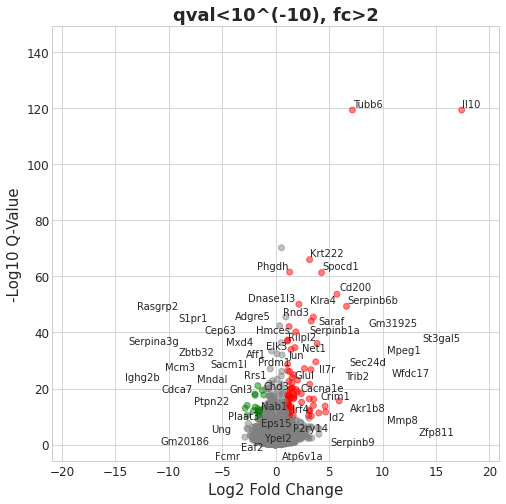

In [ ]:
results_copy = results_list[:]
fct = 2 # fold change threshold
plt.rcParams['figure.figsize']=(8,8) #rescale figures

for i in range(len(names)):
    print(names[i])
    pvt = qthresholds[i] # p value threshold

    results_copy[i] = results_copy[i].dropna()

    if abs(results_copy[i][results_copy[i].gene == "Il10"]['log2fc'].tolist()[0]) > 18 : hide = True
    else : hide = False
    volcano_plot(results_copy[i], names[i], pvt, fct, hide = hide)

In [ ]:
fct = 2 # fold change threshold

for i in range(len(names)):
    print(names[i])
    results = results_list[i]
    pvt = qthresholds[i] # p value threshold

    deg = results[(results.qval < pvt) & ((results.fc > fct) | (results.fc < 1/fct))].gene.tolist()
    deg_up = results[(results.qval < pvt) & (results.fc > fct)].gene.tolist()
    deg_down = results[(results.qval < pvt) & (results.fc < 1/fct)].gene.tolist()

    if len(deg) > 10:
        enr = gp.enrichr(gene_list=deg,
                        gene_sets=['GO_Biological_Process_2021'],
                        organism='Mouse', 
                        description='DEGs',
                        outdir='enr_plots/enr_DEGs',
                        cutoff=0.1,
                        format='png',
                        background='all_genes'
                        )
        if sum(enr.res2d['Adjusted P-value'] < 0.1) > 0:
            p = dotplot(enr.res2d[enr.res2d['Adjusted P-value'] < 0.1],title=names[i],cmap='viridis_r', column='Combined Score', legend = False, ofname = "enr_plots/"+names[i]+".png")

    fname = "figures/deg_final_"+names[i]+".xlsx"
    writer = pd.ExcelWriter(fname, engine='xlsxwriter')

    results.to_excel(writer, "everything")
    results[(results["qval"]<pvt) & ((results.fc<1/fct) | (results.fc>fct))].to_excel(writer, "significant")

    TFA = results[(results["gene"].isin(tf_list)) & (results["qval"]<pvt) & ((results.fc<1/fct) | (results.fc>fct))]
    TFA.index = range(len(TFA))
    TFB = TFA.reindex(index = range(len(TFA)+1))
    TFC = results[(results["gene"].isin(tf_list)) & (results["qval"]<pvt) & ((results.fc>1/fct) & (results.fc<fct))]
    pd.concat([TFB, TFC], ignore_index=True).to_excel(writer, "transcrip° factor")

    for j in range(len(diseases)):
        pd.DataFrame([diseases[j]]).to_excel(writer, "GWAS", startrow=0, startcol = j*4, header = False, index = False)
        results[(results["gene"].isin(GWAS[diseases[j]])) & (results["qval"]<pvt) & ((results.fc<1/fct) | (results.fc>fct))][['gene', 'fc']].to_excel(writer, 
            "GWAS", startrow=1, startcol = j*4)
    j += 1
    subsetted = results[(results["qval"]<pvt) & ((results.fc<1/fct) | (results.fc>fct)) & (abs(results['mean']) > fct)][['gene', 'mean']]
    subsetted['GWAS'] = sum([(subsetted['gene'].isin(GWAS[k])) for k in GWAS.keys()])
    subsetted[subsetted.GWAS >= 2][['gene', 'mean']].to_excel(writer, 
            "GWAS", startrow=1, startcol = j*4)

    pd.DataFrame(["UP : More accessible in N6 D2-D3"]).to_excel(writer, "ATAC", startrow=0, startcol = 0, header = False, index = False)
    atacD2_D3[atacD2_D3.gene.isin(deg_up)].to_excel(writer, "ATAC", startrow=1, startcol=0)
    pd.DataFrame(["UP : More accessible in N6 D2-D3-D7"]).to_excel(writer, "ATAC", startrow=0, startcol = 9, header = False, index = False)
    atacD2_D3_D7[atacD2_D3_D7.gene.isin(deg_up)].to_excel(writer, "ATAC", startrow=1, startcol=9)
    M = max( len(atacD2_D3[atacD2_D3.gene.isin(deg_up)]), len(atacD2_D3_D7[atacD2_D3_D7.gene.isin(deg_up)]) )
    pd.DataFrame(["DOWN : More accessible in N6 D2-D3"]).to_excel(writer, "ATAC", startrow=3+M, startcol = 0, header = False, index = False)
    atacD2_D3[atacD2_D3.gene.isin(deg_down)].to_excel(writer, "ATAC", startrow=1, startcol=4+M)
    pd.DataFrame(["DOWN : More accessible in N6 D2-D3-D7"]).to_excel(writer, "ATAC", startrow=3+M, startcol = 9, header = False, index = False)
    atacD2_D3_D7[atacD2_D3_D7.gene.isin(deg_down)].to_excel(writer, "ATAC", startrow=1, startcol=4+M)

    pd.DataFrame(["Induced by N6 at 6h"]).to_excel(writer, "6h", startrow=0, startcol = 0, header = False, index = False)
    results[(results.gene.isin(ind_n6_6)) & (results["qval"]<pvt) & ((results.fc<1/fct) | (results.fc>fct))].to_excel(writer, "6h", startrow=1, startcol=0)
    pd.DataFrame(["Inhibited by N6 at 6h"]).to_excel(writer, "6h", startrow=0, startcol = 9, header = False, index = False)
    results[(results.gene.isin(inh_n6_6)) & (results["qval"]<pvt) & ((results.fc<1/fct) | (results.fc>fct))].to_excel(writer, "6h", startrow=1, startcol=9)

    if len(deg) > 10:
        enr.results = enr.results[['Term', 'Overlap', 'Adjusted P-value', 'Odds Ratio', 'Combined Score', 'Genes']]
        enr.results = enr.results[enr.results['Adjusted P-value'] < 0.1]
        enr.results.sort_values(by="Combined Score", ascending=False).to_excel(writer, "enriched", index=False)

    book = writer.book
    imgsheet = book.add_worksheet('Volcano')
    imgsheet.insert_image('B2', "volcano_plots/volcano_"+names[i]+".png")
    imgsheet = book.add_worksheet('Enrichment')
    if len(deg) > 10:
        if sum(enr.res2d['Adjusted P-value'] < 0.1) > 0:
            imgsheet.insert_image('B2', "enr_plots/"+names[i]+".png")

    writer.save()

deg_2h_inter_6h
